<a href="https://colab.research.google.com/github/PhilipPfeffer/haptic_vest/blob/main/customnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom Neural Net

In [10]:
from numpy import loadtxt
import numpy as np
import os
import shutil
import math
import zipfile
import matplotlib.pyplot as plt

import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator

import sklearn 
from sklearn import metrics
import tensorflow_addons as tfa

#Unzip Dataset

In [4]:
dataset_name = 'dataset_cleancoco'
zip_file_path = '/content/' + dataset_name + '.zip'
unzipped_dir = '/content'
dataset_X = '/content/' + dataset_name
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzipped_dir)

#Create Dataloader

In [7]:
BATCH_SIZE = 32
ORIG_IMG_SIZE = (96, 96)
ORIG_COLOR_MODE ='grayscale'
IMG_SIZE = (96, 96)
COLOR_MODE = 'grayscale'

train_dataset = image_dataset_from_directory(dataset_X +'/train/', label_mode='categorical', shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, color_mode=COLOR_MODE)
dev_dataset = image_dataset_from_directory(dataset_X +'/dev/', label_mode='categorical', shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, color_mode=COLOR_MODE)
test_dataset = image_dataset_from_directory(dataset_X +'/test/', label_mode='categorical', shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, color_mode=COLOR_MODE)

Found 54477 files belonging to 3 classes.
Found 7105 files belonging to 3 classes.
Found 3952 files belonging to 3 classes.


In [21]:
def show_example(train_dataset):
  for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = np.asarray(image[0]).squeeze()
    print(first_image.shape)
    # for i in range(9):
    #   ax = plt.subplot(3, 3, i + 1)
      # augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
      # plt.imshow(augmented_image[0] / 255)
    # print(image)
    plt.gray()
    plt.imshow(first_image / 255, plt.get_cmap('gray'))
    plt.axis('off')
    
    break 

# Run with this line:
# show_example(train_dataset)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
dev_dataset = dev_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Get Dataset (OLD)


In [ ]:
# Definitions
# dataset ='/content/drive/My Drive/Haptic Vest/dataset_person_car'
# classes = ['neither', 'person', None , 'car']
# all_processed_imgs_dir = '/content/drive/My Drive/Haptic Vest/person_car_other_imgs_processed'

In [ ]:
# train_ids = np.loadtxt(dataset, dtype=(int, int))
# train_ids_dict = dict(train_ids)

In [ ]:
# x_train_ids, y_train_ids = train_ids[:,0], train_ids[:,1]
# assert(x_train_ids.shape == y_train_ids.shape)
# x_train_ids[0], y_train_ids[0]
# print(f"There are {len(x_train_ids)} images, set(x_train_ids) = {len(set(x_train_ids))} images.")

There are 77650 images, set(x_train_ids) = 77033 images.


In [ ]:
# ######################### 
# # CHANGE HERE
# ######################### 
# num_examples_name = '40000'
# ######################### 

# dataset_X_parent = '/content/dataset_' + num_examples_name
# dataset_X = '/content/dataset_' + num_examples_name + '/processed_subset' + num_examples_name
# # os.mkdir(dataset_X_parent)  # Uncomment if directory doesn't exist
# !unzip /content/processed_subset40000.zip -d dataset_40000

Streaming output truncated to the last 5000 lines.
  inflating: dataset_40000/__MACOSX/processed_subset40000/._000000330611.jpg  
  inflating: dataset_40000/processed_subset40000/000000431026.jpg  
  inflating: dataset_40000/__MACOSX/processed_subset40000/._000000431026.jpg  
  inflating: dataset_40000/processed_subset40000/000000581929.jpg  
  inflating: dataset_40000/__MACOSX/processed_subset40000/._000000581929.jpg  
  inflating: dataset_40000/processed_subset40000/000000107011.jpg  
  inflating: dataset_40000/__MACOSX/processed_subset40000/._000000107011.jpg  
  inflating: dataset_40000/processed_subset40000/000000319283.jpg  
  inflating: dataset_40000/__MACOSX/processed_subset40000/._000000319283.jpg  
  inflating: dataset_40000/processed_subset40000/000000081274.jpg  
  inflating: dataset_40000/__MACOSX/processed_subset40000/._000000081274.jpg  
  inflating: dataset_40000/processed_subset40000/000000226701.jpg  
  inflating: dataset_40000/__MACOSX/processed_subset40000/._0000002

## Set sizes

In [ ]:
# class_ids = [0,1,3]

In [ ]:
# dataset_X_ids = {}
# dataset_X_labels = []
# for entry in os.scandir(dataset_X):
#   if entry.is_dir() or os.path.basename(entry)[0] == '.':
#     continue
#   id = int(os.path.basename(entry)[:-4])
#   dataset_X_ids[id] = train_ids_dict[id]
#   dataset_X_labels.append(train_ids_dict[id])

# print(len(dataset_X_ids))
# print(len(dataset_X_labels))

65534
65534


In [ ]:
# dev_pct = 0.1
# test_pct = 0.05
# train_pct = 1 - dev_pct - test_pct
# assert (dev_pct + test_pct + train_pct == 1)

In [ ]:
# num_neither = np.sum(np.array(dataset_X_labels)==0)
# num_person = np.sum(np.array(dataset_X_labels)==1)
# num_car = np.sum(np.array(dataset_X_labels)==3)
# num_class_examples = {0:num_neither, 1:num_person, 3: num_car}
# print(num_class_examples, num_neither +num_person + num_car)

{0: 37585, 1: 25470, 3: 2479} 65534


In [ ]:
# num_test = {key: int(test_pct * num_class) for key, num_class in num_class_examples.items()}
# num_dev = {key: int(dev_pct * num_class) for key, num_class in num_class_examples.items()}
# num_train = {class_id: num_class_examples[class_id] - num_dev[class_id] - num_test[class_id] for class_id in class_ids}

# print(num_test, "\n", num_dev, "\n", num_train)

{0: 1879, 1: 1273, 3: 123} 
 {0: 3758, 1: 2547, 3: 247} 
 {0: 31948, 1: 21650, 3: 2109}


In [ ]:
# # In case of fuck up, reset folders
# !rm -r /content/dataset_40000/processed_subset40000/dev
# !rm -r /content/dataset_40000/processed_subset40000/test
# !rm -r /content/dataset_40000/processed_subset40000/train

# !mkdir /content/dataset_40000/processed_subset40000/dev
# !mkdir /content/dataset_40000/processed_subset40000/dev/0
# !mkdir /content/dataset_40000/processed_subset40000/dev/1
# !mkdir /content/dataset_40000/processed_subset40000/dev/3

# !mkdir /content/dataset_40000/processed_subset40000/test
# !mkdir /content/dataset_40000/processed_subset40000/test/0
# !mkdir /content/dataset_40000/processed_subset40000/test/1
# !mkdir /content/dataset_40000/processed_subset40000/test/3

# !mkdir /content/dataset_40000/processed_subset40000/train
# !mkdir /content/dataset_40000/processed_subset40000/train/0
# !mkdir /content/dataset_40000/processed_subset40000/train/1
# !mkdir /content/dataset_40000/processed_subset40000/train/3

rm: cannot remove '/content/dataset_40000/processed_subset40000/dev': No such file or directory
rm: cannot remove '/content/dataset_40000/processed_subset40000/test': No such file or directory
rm: cannot remove '/content/dataset_40000/processed_subset40000/train': No such file or directory


In [ ]:
# def path_to_id(path):
#   return int(os.path.basename(entry)[:-4])

In [ ]:
# num_test_done = {class_id: 0 for class_id in class_ids}
# num_dev_done = {class_id: 0 for class_id in class_ids}
# num_train_done = {class_id: 0 for class_id in class_ids}
# for idx, entry in enumerate(os.scandir(dataset_X)):
#   if entry.is_dir() or os.path.basename(entry)[0] == '.':
#     continue
#   id = path_to_id(entry)
#   label = train_ids_dict[id]
  
#   if num_train_done[label] != num_train[label]:
#     num_train_done[label] += 1
#     shutil.copyfile(entry, dataset_X + '/train/' + str(label) + '/' + os.path.basename(entry))
#   elif num_dev_done[label] != num_dev[label]:
#     num_dev_done[label] += 1
#     shutil.copyfile(entry, dataset_X + '/dev/' + str(label) + '/' + os.path.basename(entry))
#   elif num_test_done[label] != num_test[label]:
#     num_test_done[label] += 1
#     shutil.copyfile(entry, dataset_X + '/test/' + str(label) + '/' + os.path.basename(entry))
  
#   if idx % 5000 == 0:
#     print(idx, num_train_done, num_dev_done, num_test_done)

0 {0: 1, 1: 0, 3: 0} {0: 0, 1: 0, 3: 0} {0: 0, 1: 0, 3: 0}
5000 {0: 2913, 1: 1915, 3: 173} {0: 0, 1: 0, 3: 0} {0: 0, 1: 0, 3: 0}
10000 {0: 5756, 1: 3888, 3: 357} {0: 0, 1: 0, 3: 0} {0: 0, 1: 0, 3: 0}
15000 {0: 8593, 1: 5849, 3: 558} {0: 0, 1: 0, 3: 0} {0: 0, 1: 0, 3: 0}
20000 {0: 11499, 1: 7745, 3: 755} {0: 0, 1: 0, 3: 0} {0: 0, 1: 0, 3: 0}
25000 {0: 14358, 1: 9682, 3: 958} {0: 0, 1: 0, 3: 0} {0: 0, 1: 0, 3: 0}
30000 {0: 17231, 1: 11630, 3: 1137} {0: 0, 1: 0, 3: 0} {0: 0, 1: 0, 3: 0}
35000 {0: 20048, 1: 13638, 3: 1312} {0: 0, 1: 0, 3: 0} {0: 0, 1: 0, 3: 0}
40000 {0: 22957, 1: 15541, 3: 1500} {0: 0, 1: 0, 3: 0} {0: 0, 1: 0, 3: 0}
45000 {0: 25811, 1: 17493, 3: 1694} {0: 0, 1: 0, 3: 0} {0: 0, 1: 0, 3: 0}
50000 {0: 28669, 1: 19422, 3: 1907} {0: 0, 1: 0, 3: 0} {0: 0, 1: 0, 3: 0}
55000 {0: 31500, 1: 21404, 3: 2094} {0: 0, 1: 0, 3: 0} {0: 0, 1: 0, 3: 0}
60000 {0: 31948, 1: 21650, 3: 2109} {0: 2408, 1: 1723, 3: 159} {0: 0, 1: 0, 3: 0}
65000 {0: 31948, 1: 21650, 3: 2109} {0: 3758, 1: 2547, 3: 2

In [ ]:
print(num_train_done, num_dev_done, num_test_done)

{0: 31948, 1: 21650, 3: 2109} {0: 3758, 1: 2547, 3: 247} {0: 1879, 1: 1273, 3: 123}


In [ ]:
# # create generator
# datagen_X = ImageDataGenerator()
# # prepare an iterators for each dataset
# train_it = datagen_X.flow_from_directory(dataset_X +'/train/', class_mode='categorical', color_mode='grayscale', target_size=(96,96))
# dev_it = datagen_X.flow_from_directory(dataset_X +'/dev/', class_mode='categorical', color_mode='grayscale', target_size=(96,96))
# test_it = datagen_X.flow_from_directory(dataset_X +'/test/', class_mode='categorical', color_mode='grayscale', target_size=(96,96))
# # confirm the iterator works
# batchX, batchy = train_it.next()
# print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Found 55707 images belonging to 3 classes.
Found 6552 images belonging to 3 classes.
Found 3275 images belonging to 3 classes.
Batch shape=(32, 96, 96, 1), min=0.000, max=255.000


# GPU Setup

In [22]:

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Create Model

In [26]:
model = keras.Sequential(
    [
        keras.Input(shape=(IMG_SIZE[0],IMG_SIZE[1], 1)),  # 96x96 greyscale image
        layers.Conv2D(filters=8, kernel_size=3, strides=1, padding='same', activation="relu"),
        layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation="relu"),
        layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation="relu"),
        layers.MaxPool2D(),
        layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation="relu"),        # layers.MaxPool2D(),
        layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation="relu"),
        layers.MaxPool2D(),
        layers.Flatten(name='flatten'),
        Dense(100, activation='relu'),
        Dense(100, activation='relu'),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 8)         80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 16)        1168      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0

In [27]:
# Compile model with accuracy and weighted F1 Score
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tfa.metrics.F1Score(num_classes=3, average="weighted")])

# Initial Model Training

## Initial results without training

In [28]:
loss0, accuracy0, f1_score0 = model.evaluate(dev_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
print("initial f1_score: {:.2f}".format(f1_score0))

223/223 [==============================] - 4s 19ms/step - loss: 9.6391 - accuracy: 0.0773 - f1_score: 0.0111
initial loss: 9.64
initial accuracy: 0.08
initial f1_score: 0.01


## Fit (Initial)

In [30]:
initial_epochs = 10

In [31]:
with tf.device('/device:GPU:0'):
  history = model.fit(train_dataset,
                  epochs=initial_epochs,
                  validation_data=dev_dataset)
  # model.fit(train_it, epochs=20, batch_size=batchX.shape[0], validation_data=dev_it, validation_batch_size=batchX.shape[0])

Epoch 1/10
1703/1703 [==============================] - 51s 30ms/step - loss: 0.6415 - accuracy: 0.6789 - f1_score: 0.6718 - val_loss: 0.8989 - val_accuracy: 0.6480 - val_f1_score: 0.6232
Epoch 2/10
1703/1703 [==============================] - 50s 29ms/step - loss: 0.6085 - accuracy: 0.7038 - f1_score: 0.6982 - val_loss: 0.8687 - val_accuracy: 0.6719 - val_f1_score: 0.6460
Epoch 3/10
1703/1703 [==============================] - 50s 29ms/step - loss: 0.5804 - accuracy: 0.7245 - f1_score: 0.7193 - val_loss: 0.8578 - val_accuracy: 0.6774 - val_f1_score: 0.6464
Epoch 4/10
1703/1703 [==============================] - 50s 29ms/step - loss: 0.5461 - accuracy: 0.7477 - f1_score: 0.7425 - val_loss: 0.8911 - val_accuracy: 0.6752 - val_f1_score: 0.6457
Epoch 5/10
1703/1703 [==============================] - 50s 29ms/step - loss: 0.5027 - accuracy: 0.7756 - f1_score: 0.7707 - val_loss: 0.8962 - val_accuracy: 0.6740 - val_f1_score: 0.6457
Epoch 6/10
1703/1703 [==============================] - 49s 

## Learning Plot

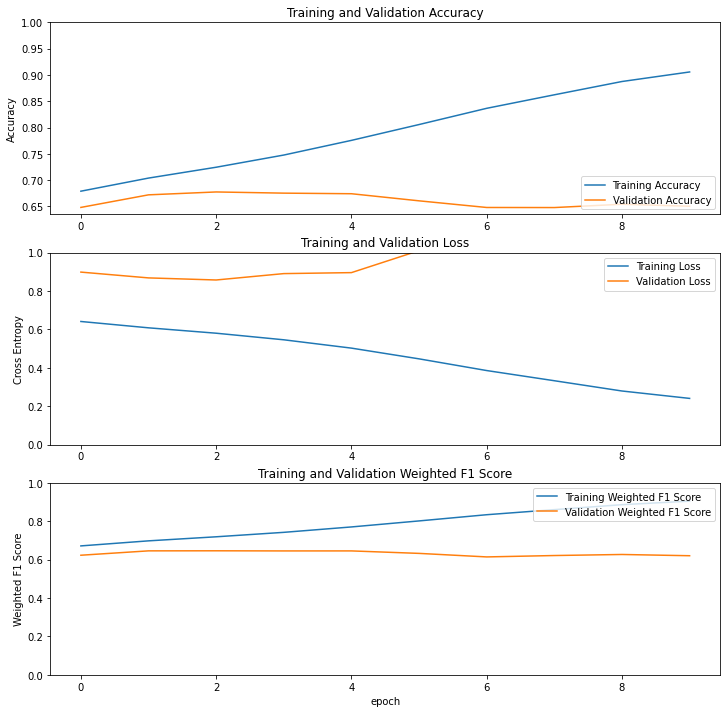

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


f1_score = history.history['f1_score']
val_f1_score = history.history['val_f1_score']

plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(3, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')

plt.subplot(3, 1, 3)
plt.plot(f1_score, label='Training Weighted F1 Score')
plt.plot(val_f1_score, label='Validation Weighted F1 Score')
plt.legend(loc='upper right')
plt.ylabel('Weighted F1 Score')
plt.ylim([0,1.0])
plt.title('Training and Validation Weighted F1 Score')
plt.xlabel('epoch')
plt.show()

# Rounded Weights Evaluation

In [60]:
def modify_weights(weights, transform):
  for layer_num, layer_weights in enumerate(weights):
    if layer_num == len(weights)-1:
      print(f"=============== Layer {layer_num} ===============\n")
      print(transform(layer_weights))
      print('\n')

def round2(layer_weights):
  return np.round_(layer_weights, 2)

def closest_pow_2(layer_weights):
  return 2**(-np.round_(np.log2(np.absolute(layer_weights))))

transform = round2
transform = closest_pow_2

weights = model.get_weights() # returs a numpy list of weights
modify_weights(weights, transform)

=============== Layer 17 ===============

[  8. 256.   2.]




# Evaluate on Test Set
(COMMENTED until development finished)

In [33]:
# _, accuracy = model.evaluate(dev_it)
# print('Accuracy: %.2f' % (accuracy*100))

# Convert tf model to tflite

In [ ]:
# Convert
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)